# Optimization and Topological Data Analysis

Mathieu Carrière, https://mathieucarriere.github.io/website/

In this notebook, we are going to see how to combine Gudhi and Tensorflow in order to do persistence optimization!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd

## Point cloud optimization

You might have already seen a few examples of persistence diagram computations on point clouds. Among the different possibilities, the Rips filtration is the most common option due to its simplicity and easy implementation. In this notebook, we will see how Gudhi and Tensorflow can be combined to perform optimization of persistence diagrams.

Let's have a quick refresher ;-)

First, let's generate a random point cloud in the unit square and visualize it.

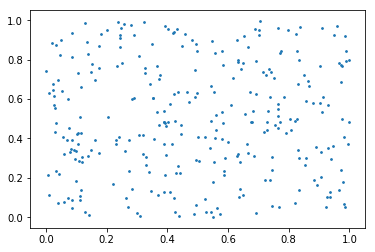

In [2]:
X = np.random.uniform(size=[300,2])
plt.scatter(X[:,0], X[:,1], s=3)
plt.show()

Yep, looks pretty random indeed. Let's now compute its Rips persistence diagram. This is literally two lines of code with Gudhi :-)

In [3]:
st = gd.RipsComplex(points=X, max_edge_length=1.).create_simplex_tree(max_dimension=2)
dgm = st.persistence()

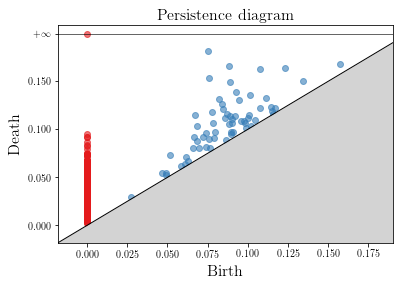

In [4]:
plot = gd.plot_persistence_diagram(dgm)

As usual, there is one point (in dimension 0) at $+\infty$ which represents the whole connected component, a bunch of points in dimension 0 with abscissa 0 (actually, as many as there are points in the initial point cloud), and some points in dimension 1. There is nothing else because we only kept the 2-skeleton of the Rips complex in the previous cell.

This is great. But have you ever thought about the inverse problem? That is, can you tweak the point cloud so that the corresponding persistence diagram satisfies some properties? That sounds hard. Turns out it is not if you combine Gudhi and Tensorflow ;-)

Before jumping to the code, let's think about what's happening here. If you think about how persistence is computed, the coordinates of any point $p$ in a persistence diagram are actually given by the filtration values of two very specific simplices: the so-called positive and negative simplices of $p$, denoted by $\sigma_+(p)$ and $\sigma_-(p)$ (check chapter VII.1 in [this reference book](https://books.google.com/books/about/Computational_Topology.html?id=MDXa6gFRZuIC) for more details if you feel lost). So, we have: $$p=(f(\sigma_+(p)), f(\sigma_-(p))),$$
where $f$ is the filtration function. This means that if $f$ is actually defined by some parameters $f = f_\theta$, then the gradient $\nabla_\theta p$ is actually given by $\nabla_\theta f_\theta(\sigma_+(p))$ and $\nabla_\theta f_\theta(\sigma_-(p))$.

Interesting, but how does this look like for the Rips filtration? Well, first, the parameters $\theta$ are now the positions of the points in the point cloud. Second, as you may recall, the filtration value of any simplex is simply the maximal distance between any two vertices in the simplex: $f(\{v_0,\cdots, v_n\})=\|v_a-v_b\|$, $0\leq a,b\leq n$, where $\|v_a-v_b\|\geq \|v_i-v_j\|$, $\forall 0\leq i,j \leq n$. This has two consequences. First, this means that one can create the persistence diagram by simply picking entries of the distance matrix between the points. Second, this also means that the gradient of $f$ only depends on the positions of $v_a$ and $v_b$: $\nabla f=\frac{v_a-v_b}{\|v_a-v_b\|}$. You can check [this article](https://arxiv.org/abs/1506.03147) for more details.

All right! So the only thing that remains to do is to compute the positive and negative simplices, right? Turns out that Gudhi can do that with the `persistence_pairs()` function. Well, let's go then!

First, let's write a function that computes the positive and negative simplices associated to the persistence pairs of a Rips persistence diagram, and outputs the vertices $v_a$ and $v_b$ associated to these simplices. 

In [5]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

Second, we define a Tensorflow model whose parameters are the point coordinates, and which outputs the corresponding Rips persistence diagram.

In [6]:
class RipsModel(tf.keras.Model):
    def __init__(self, X, mel=12, dim=1, card=50):
        super(RipsModel, self).__init__()
        self.X = X
        self.mel = mel
        self.dim = dim
        self.card = card
        
    def call(self):
        m, d, c = self.mel, self.dim, self.card
        
        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(self.X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        RipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        ids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(RipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        dgm = tf.reshape(tf.gather_nd(DX, tf.reshape(ids, [2*c,2])), [c,2])
        return dgm

Finally, we are done! Let's define our parameters.

In [7]:
n_pts    = 300   # number of points in the point clouds
card     = 50    # max number of points in the diagrams
hom      = 1     # homological dimension
ml       = 12.   # max distance in Rips
n_epochs = 30    # number of optimization steps

We randomly initalize our point cloud.

In [8]:
Xinit = np.array(np.random.uniform(size=(n_pts,2)), dtype=np.float32)
X = tf.Variable(initial_value=Xinit, trainable=True)

We define our Tensorflow model + optimizer.

In [9]:
model = RipsModel(X=X, mel=ml, dim=hom, card=card)

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

Finally, we can launch the optimization! Our loss is the opposite of the sum of squares of the distances to the diagonal of the points in the diagram. This will force the persistence diagram to have many prominent points, and thus the point cloud will contain as much loops as possible. Let's train  and visualize the point cloud every 10 iterations, or epochs!

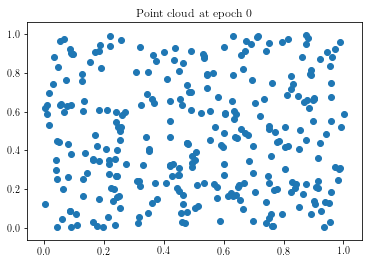

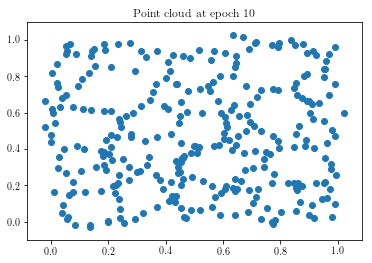

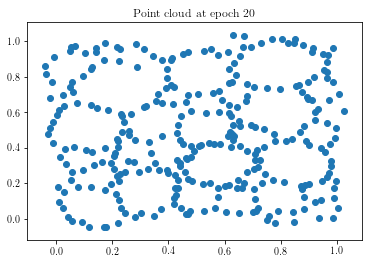

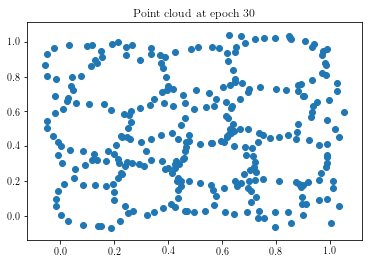

In [11]:
for epoch in range(n_epochs+1):
    
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        dgm = model.call()
        
        # Loss is sum of squares of distances to the diagonal
        loss = -tf.math.reduce_sum(tf.square(.5*(dgm[:,1]-dgm[:,0])))
        
        # Compute and apply gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 10 == 0:
        plt.figure()
        plt.scatter(model.X.numpy()[:,0], model.X.numpy()[:,1])
        plt.title("Point cloud at epoch " + str(epoch))
        plt.show()

Looks like there are more cycles indeed ;-)

## Image optimization

We can actually play the same game with images! Indeed, Gudhi contains code for computing [cubical persistence](http://www2.im.uj.edu.pl/mpd/publications/Wagner_persistence.pdf), which is very well-suited for handling images. For instance, it can be used to filter a 2D image with its pixel values. Overall, the optimization follows the exact same steps as before, except that we use pixel filtration instead of Rips filtration. This means that the parameters $\theta$ that we are now going to optimize are the pixel values themselves, and that the gradients for positive simplex $\nabla_\theta f_\theta(\sigma_+(p))$ and negative simplex $\nabla_\theta f_\theta(\sigma_-(p))$ now simply equal $1$ for the pixels associated to $\sigma_+(p)$ and $\sigma_-(p)$ and $0$ for all other pixels.

Fortunately, Gudhi contains a function `cofaces_of_persistence_pairs()` that exactly retrieves the pixels (or, more formally, the cofaces) of the positive and negative simplices of a persistence point $p$.

Let's start with a function that computes those pixels.

In [12]:
def Cubical(X, dim, card):
    # Parameters: X (image),
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    cc = gd.CubicalComplex(dimensions=X.shape, top_dimensional_cells=X.flatten())
    cc.persistence()
    cof = cc.cofaces_of_persistence_pairs()[0][dim]
    
    # Sort points with distance-to-diagonal
    Xs = X.shape
    pers = [X[np.unravel_index(cof[idx,1], Xs)] - X[np.unravel_index(cof[idx,0], Xs)] for idx in range(len(cof))]
    perm = np.argsort(pers)
    cof = cof[perm]
    
    # Retrieve and ouput image indices/pixels corresponding to positive and negative simplices
    D = len(X.shape)
    ocof = np.array([0 for _ in range(D*card*2)])
    for idx in range(len(cof[:min(card, cof.shape[0])])):
        ocof[D*idx:D*(idx+1)]     = np.unravel_index(cof[idx,0], X.shape)
        ocof[D*(idx+1):D*(idx+2)] = np.unravel_index(cof[idx,1], X.shape)
    return list(np.array(ocof.flatten(), dtype=np.int32))

As before, we now define a corresponding Tensorflow model.

In [13]:
class CubicalModel(tf.keras.Model):
    def __init__(self, X, dim=1, card=50):
        super(CubicalModel, self).__init__()
        self.X = X
        self.dim = dim
        self.card = card
        
    def call(self):
        d, c, D = self.dim, self.card, len(self.X.shape)
        XX = tf.reshape(self.X, [1, self.X.shape[0], self.X.shape[1]])
        
        # Turn numpy function into tensorflow function
        CbTF = lambda X: tf.numpy_function(Cubical, [X, d, c], [tf.int32 for _ in range(2*D*c)])
        
        # Compute pixels associated to positive and negative simplices 
        # Don't compute gradient for this operation
        inds = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(CbTF,XX,dtype=[tf.int32 for _ in range(2*D*c)]))
        
        # Get persistence diagram by simply picking the corresponding entries in the image
        dgm = tf.reshape(tf.gather_nd(self.X, tf.reshape(inds, [-1,D])), [-1,2])
        return dgm

All right! Let's apply all of these now! We are going to use the following image:

In [14]:
I = np.array(pd.read_csv("datasets/mnist_test.csv", header=None, sep=","), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])

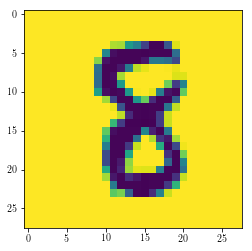

In [15]:
plt.figure()
plt.imshow(image)
plt.show()

As you can see, the upper loop of this 8 is not complete. Since it corresponds to 1-dimensional topology, we can fix this by optimizing the pixel values so that the points in the 1-dimensional persistence diagram have maximal persistence. 

We first define the network parameters.

In [16]:
card     = 50   # max number of points in the diagrams
hom      = 1    # homological dimension
n_epochs = 100  # number of optimization steps

We define our Tensorflow model + optimizer.

In [17]:
X = tf.Variable(initial_value=np.array(image, dtype=np.float32), trainable=True)
model = CubicalModel(X, dim=hom, card=card)

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5*1e-2)

This time, our loss is the sum of the squared birth coodinates of the persistence diagram points, so that the loops will appear as soon as possible, and the values of the corresponding pixels will be as dark as possible. Let's train  and visualize the image every 10 iterations, or epochs!

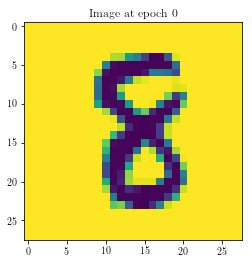

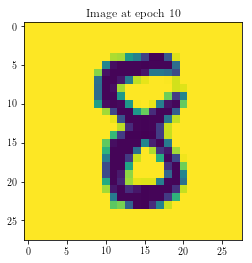

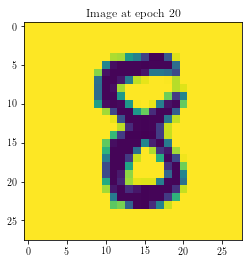

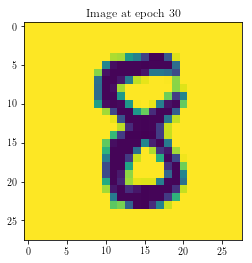

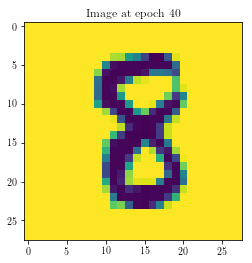

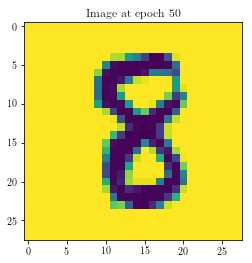

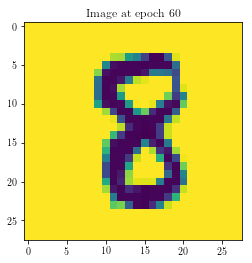

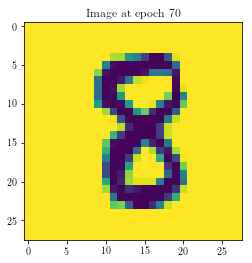

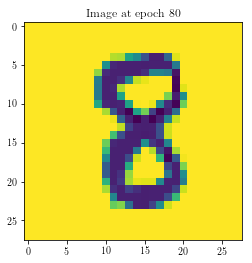

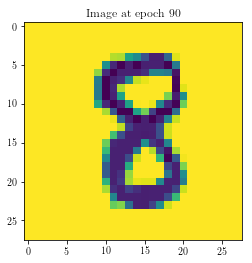

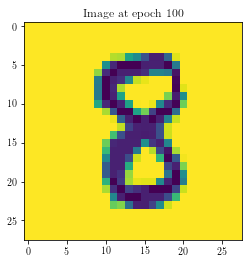

In [19]:
for epoch in range(n_epochs+1):
    
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        dgm = model.call()
        
        # Loss is sum of squared birth coordinates
        loss = -tf.math.reduce_sum(tf.square(dgm[:,0]))
        
        # Compute and apply gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 10 == 0:
        plt.figure()
        plt.imshow(model.X.numpy())
        plt.title("Image at epoch " + str(epoch))
        plt.show()

This upper loop looks definitely fixed now! :-)